### You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store. 
 

In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (18, 12)
plt.rcParams['axes.grid'] = True
plt.gray();

import seaborn as sns 
import pandas_profiling
import scipy.stats as stats
import statsmodels.formula.api as smf
import sklearn as sk

<Figure size 1296x864 with 0 Axes>

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')
submission = pd.read_csv('sampleSubmission.csv')

First merging files / Pre-Process

In [3]:
train_store = pd.merge(train, stores)
test_store = pd.merge(train, stores)   

new_train = pd.merge(train_store, features)
new_test = pd.merge(test_store, features)

In [4]:
print(new_train.head(2))
print(new_test.head(2))

   Store  Dept        Date  Weekly_Sales  IsHoliday Type    Size  Temperature  \
0      1     1  2010-02-05      24924.50      False    A  151315        42.31   
1      1     2  2010-02-05      50605.27      False    A  151315        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.572        NaN        NaN        NaN        NaN        NaN   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.096358         8.106  
   Store  Dept        Date  Weekly_Sales  IsHoliday Type    Size  Temperature  \
0      1     1  2010-02-05      24924.50      False    A  151315        42.31   
1      1     2  2010-02-05      50605.27      False    A  151315        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.572        NaN        NaN        NaN        NaN    

In [5]:
print (new_train.info())
print ('***************************************')
print (new_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB
None
***************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null

### Data Description
#### Training the Data

In [6]:
num_var_train = [key for key in dict(new_train.dtypes) if dict(new_train.dtypes)[key] in ['float64', 'int64']]
cat_var_train = [key for key in dict(new_train.dtypes) if dict(new_train.dtypes)[key] in ['object']]

train_num = new_train[num_var_train]
train_cat = new_train[cat_var_train]

print(num_var_train)
print('')
print(cat_var_train)

['Store', 'Dept', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']

['Date', 'Type']


In [7]:
num_var_test = [key for key in dict(new_test.dtypes) if dict(new_test.dtypes)[key] in ['float64', 'int64']]
cat_var_test = [key for key in dict(new_test.dtypes) if dict(new_test.dtypes)[key] in ['object']]

test_num = new_test[num_var_test]
test_cat = new_test[cat_var_test]

print(num_var_test)
print()
print(cat_var_test)

['Store', 'Dept', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']

['Date', 'Type']


#### Creating Data Audit report with codes / general function

In [8]:
# For Output_excel file...
writer=pd.ExcelWriter('Walmart Store Sales Prediction output.xlsx', engine='xlsxwriter')

In [9]:
def feature_summary_num(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(), x.std(), x.var(),
                     x.min(), x.max(), x.dropna().quantile(0.25), x.dropna().quantile(0.50), x.dropna().quantile(0.75)],
                    index = ['N', 'NMiss', 'Sum', 'Mean', 'Median', 'SD', 'var', 'Min', 'Max', 'P25', 'P50', 'P75'])
data_audit_report_train_num = train_num.apply(lambda x: feature_summary_num(x)).T
data_audit_report_train_num.to_excel(writer, 'Train_Num Summary', index = True)
data_audit_report_train_num

N     NMiss           Sum           Mean        Median  \
Store         421570.0       0.0  9.359084e+06      22.200546      22.00000   
Dept          421570.0       0.0  1.865882e+07      44.260317      37.00000   
Weekly_Sales  421570.0       0.0  6.737219e+09   15981.258123    7612.03000   
Size          421570.0       0.0  5.764039e+10  136727.915739  140167.00000   
Temperature   421570.0       0.0  2.533217e+07      60.090059      62.09000   
Fuel_Price    421570.0       0.0  1.416908e+06       3.361027       3.45200   
MarkDown1     150681.0  270889.0  1.091898e+09    7246.420196    5347.45000   
MarkDown2     111248.0  310322.0  3.709708e+08    3334.628621     192.00000   
MarkDown3     137091.0  284479.0  1.973317e+08    1439.421384      24.60000   
MarkDown4     134967.0  286603.0  4.566161e+08    3383.168256    1481.31000   
MarkDown5     151432.0  270138.0  7.009750e+08    4628.975079    3359.45000   
CPI           421570.0       0.0  7.217360e+07     171.201947     182.31878   
Unemployment  421570.0       0.0  3.355819e+06       7.960289       7.86600   

                        SD           var        Min            Max  \
Store            12.785297  1.634638e+02      1.000      45.000000   
Dept             30.492054  9.297654e+02      1.000      99.000000   
Weekly_Sales  22711.183519  5.157979e+08  -4988.940  693099.360000   
Size          60980.583328  3.718632e+09  34875.000  219622.000000   
Temperature      18.447931  3.403262e+02     -2.060     100.140000   
Fuel_Price        0.458515  2.102356e-01      2.472       4.468000   
MarkDown1      8291.221345  6.874435e+07      0.270   88646.760000   
MarkDown2      9475.357325  8.978240e+07   -265.760  104519.540000   
MarkDown3      9623.078290  9.260364e+07    -29.100  141630.610000   
MarkDown4      6292.384031  3.959410e+07      0.220   67474.850000   
MarkDown5      5962.887455  3.555603e+07    135.160  108519.280000   
CPI              39.159276  1.533449e+03    126.064     227.232807   
Unemployment      1.863296  3.471872e+00      3.879      14.313000   

                       P25           P50            P75  
Store            11.000000      22.00000      33.000000  
Dept             18.000000      37.00000      74.000000  
Weekly_Sales   2079.650000    7612.03000   20205.852500  
Size          93638.000000  140167.00000  202505.000000  
Temperature      46.680000      62.09000      74.280000  
Fuel_Price        2.933000       3.45200       3.738000  
MarkDown1      2240.270000    5347.45000    9210.900000  
MarkDown2        41.600000     192.00000    1926.940000  
MarkDown3         5.080000      24.60000     103.990000  
MarkDown4       504.220000    1481.31000    3595.040000  
MarkDown5      1878.440000    3359.45000    5563.800000  
CPI             132.022667     182.31878     212.416993  
Unemployment      6.891000       7.86600       8.572000

In [10]:
def feature_summary_cat(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()],
                    index = ['N', 'NMiss', 'ColNames'])

data_audit_report_train_cat = train_cat.apply(lambda x: feature_summary_cat(x))
data_audit_report_train_cat

Date  \
N                                                    421570   
NMiss                                                     0   
ColNames  2011-12-23    3027
2011-11-25    3021
2011-12-...   

                                                       Type  
N                                                    421570  
NMiss                                                     0  
ColNames  A    215478
B    163495
C     42597
Name: Type...

In [11]:
data_audit_report_test_num=test_num.apply(lambda x: feature_summary_num(x)).T
data_audit_report_test_num.to_excel(writer,'Numeric_variable Summary',index=True)
data_audit_report_test_num

N     NMiss           Sum           Mean        Median  \
Store         421570.0       0.0  9.359084e+06      22.200546      22.00000   
Dept          421570.0       0.0  1.865882e+07      44.260317      37.00000   
Weekly_Sales  421570.0       0.0  6.737219e+09   15981.258123    7612.03000   
Size          421570.0       0.0  5.764039e+10  136727.915739  140167.00000   
Temperature   421570.0       0.0  2.533217e+07      60.090059      62.09000   
Fuel_Price    421570.0       0.0  1.416908e+06       3.361027       3.45200   
MarkDown1     150681.0  270889.0  1.091898e+09    7246.420196    5347.45000   
MarkDown2     111248.0  310322.0  3.709708e+08    3334.628621     192.00000   
MarkDown3     137091.0  284479.0  1.973317e+08    1439.421384      24.60000   
MarkDown4     134967.0  286603.0  4.566161e+08    3383.168256    1481.31000   
MarkDown5     151432.0  270138.0  7.009750e+08    4628.975079    3359.45000   
CPI           421570.0       0.0  7.217360e+07     171.201947     182.31878   
Unemployment  421570.0       0.0  3.355819e+06       7.960289       7.86600   

                        SD           var        Min            Max  \
Store            12.785297  1.634638e+02      1.000      45.000000   
Dept             30.492054  9.297654e+02      1.000      99.000000   
Weekly_Sales  22711.183519  5.157979e+08  -4988.940  693099.360000   
Size          60980.583328  3.718632e+09  34875.000  219622.000000   
Temperature      18.447931  3.403262e+02     -2.060     100.140000   
Fuel_Price        0.458515  2.102356e-01      2.472       4.468000   
MarkDown1      8291.221345  6.874435e+07      0.270   88646.760000   
MarkDown2      9475.357325  8.978240e+07   -265.760  104519.540000   
MarkDown3      9623.078290  9.260364e+07    -29.100  141630.610000   
MarkDown4      6292.384031  3.959410e+07      0.220   67474.850000   
MarkDown5      5962.887455  3.555603e+07    135.160  108519.280000   
CPI              39.159276  1.533449e+03    126.064     227.232807   
Unemployment      1.863296  3.471872e+00      3.879      14.313000   

                       P25           P50            P75  
Store            11.000000      22.00000      33.000000  
Dept             18.000000      37.00000      74.000000  
Weekly_Sales   2079.650000    7612.03000   20205.852500  
Size          93638.000000  140167.00000  202505.000000  
Temperature      46.680000      62.09000      74.280000  
Fuel_Price        2.933000       3.45200       3.738000  
MarkDown1      2240.270000    5347.45000    9210.900000  
MarkDown2        41.600000     192.00000    1926.940000  
MarkDown3         5.080000      24.60000     103.990000  
MarkDown4       504.220000    1481.31000    3595.040000  
MarkDown5      1878.440000    3359.45000    5563.800000  
CPI             132.022667     182.31878     212.416993  
Unemployment      6.891000       7.86600       8.572000

In [12]:
data_audit_report_test_cat = test_cat.apply(lambda x: feature_summary_cat(x))
data_audit_report_test_cat

Date  \
N                                                    421570   
NMiss                                                     0   
ColNames  2011-12-23    3027
2011-11-25    3021
2011-12-...   

                                                       Type  
N                                                    421570  
NMiss                                                     0  
ColNames  A    215478
B    163495
C     42597
Name: Type...

#### Data Audit report using pandas_profiling

In [13]:
import pandas_profiling

In [14]:
#for train
pandas_profiling.ProfileReport(new_train)

In [15]:
pandas_profiling.ProfileReport(new_test)

### Correlation

In [16]:
train_correlation = pd.DataFrame(new_train.corr())
train_correlation

Store      Dept  Weekly_Sales  IsHoliday      Size  \
Store         1.000000  0.024004     -0.085195  -0.000548 -0.182881   
Dept          0.024004  1.000000      0.148032   0.000916 -0.002966   
Weekly_Sales -0.085195  0.148032      1.000000   0.012774  0.243828   
IsHoliday    -0.000548  0.000916      0.012774   1.000000  0.000593   
Size         -0.182881 -0.002966      0.243828   0.000593  1.000000   
Temperature  -0.050097  0.004437     -0.002312  -0.155949 -0.058313   
Fuel_Price    0.065290  0.003572     -0.000120  -0.078281  0.003361   
MarkDown1    -0.119588 -0.002426      0.085251  -0.035586  0.345673   
MarkDown2    -0.035173  0.000290      0.024130   0.334818  0.108827   
MarkDown3    -0.031556  0.001784      0.060385   0.427960  0.048913   
MarkDown4    -0.009941  0.004257      0.045414  -0.000562  0.168196   
MarkDown5    -0.026634  0.000109      0.090362  -0.053719  0.304575   
CPI          -0.211088 -0.007477     -0.020921  -0.001944 -0.003314   
Unemployment  0.208552  0.007837     -0.025864   0.010460 -0.068238   

              Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
Store           -0.050097    0.065290  -0.119588  -0.035173  -0.031556   
Dept             0.004437    0.003572  -0.002426   0.000290   0.001784   
Weekly_Sales    -0.002312   -0.000120   0.085251   0.024130   0.060385   
IsHoliday       -0.155949   -0.078281  -0.035586   0.334818   0.427960   
Size            -0.058313    0.003361   0.345673   0.108827   0.048913   
Temperature      1.000000    0.143859  -0.040594  -0.323927  -0.096880   
Fuel_Price       0.143859    1.000000   0.061371  -0.220895  -0.102092   
MarkDown1       -0.040594    0.061371   1.000000   0.024486  -0.108115   
MarkDown2       -0.323927   -0.220895   0.024486   1.000000  -0.050108   
MarkDown3       -0.096880   -0.102092  -0.108115  -0.050108   1.000000   
MarkDown4       -0.063947   -0.044986   0.819238  -0.007768  -0.071095   
MarkDown5       -0.017544   -0.128065   0.160257  -0.007440  -0.026467   
CPI              0.182112   -0.164210  -0.055558  -0.039534  -0.023590   
Unemployment     0.096730   -0.033853   0.050285   0.020940   0.012818   

              MarkDown4  MarkDown5       CPI  Unemployment  
Store         -0.009941  -0.026634 -0.211088      0.208552  
Dept           0.004257   0.000109 -0.007477      0.007837  
Weekly_Sales   0.045414   0.090362 -0.020921     -0.025864  
IsHoliday     -0.000562  -0.053719 -0.001944      0.010460  
Size           0.168196   0.304575 -0.003314     -0.068238  
Temperature   -0.063947  -0.017544  0.182112      0.096730  
Fuel_Price    -0.044986  -0.128065 -0.164210     -0.033853  
MarkDown1      0.819238   0.160257 -0.055558      0.050285  
MarkDown2     -0.007768  -0.007440 -0.039534      0.020940  
MarkDown3     -0.071095  -0.026467 -0.023590      0.012818  
MarkDown4      1.000000   0.107792 -0.049628      0.024963  
MarkDown5      0.107792   1.000000  0.060630     -0.003843  
CPI           -0.049628   0.060630  1.000000     -0.299953  
Unemployment   0.024963  -0.003843 -0.299953      1.000000

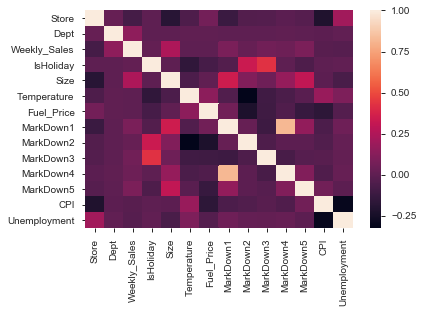

In [17]:
# visualize correlation matrix in Seaborn using a heatmap
fig1 = sns.heatmap(new_train.corr())
fig1;

In [18]:
test_correlation = pd.DataFrame(new_test.corr())
test_correlation

Store      Dept  Weekly_Sales  IsHoliday      Size  \
Store         1.000000  0.024004     -0.085195  -0.000548 -0.182881   
Dept          0.024004  1.000000      0.148032   0.000916 -0.002966   
Weekly_Sales -0.085195  0.148032      1.000000   0.012774  0.243828   
IsHoliday    -0.000548  0.000916      0.012774   1.000000  0.000593   
Size         -0.182881 -0.002966      0.243828   0.000593  1.000000   
Temperature  -0.050097  0.004437     -0.002312  -0.155949 -0.058313   
Fuel_Price    0.065290  0.003572     -0.000120  -0.078281  0.003361   
MarkDown1    -0.119588 -0.002426      0.085251  -0.035586  0.345673   
MarkDown2    -0.035173  0.000290      0.024130   0.334818  0.108827   
MarkDown3    -0.031556  0.001784      0.060385   0.427960  0.048913   
MarkDown4    -0.009941  0.004257      0.045414  -0.000562  0.168196   
MarkDown5    -0.026634  0.000109      0.090362  -0.053719  0.304575   
CPI          -0.211088 -0.007477     -0.020921  -0.001944 -0.003314   
Unemployment  0.208552  0.007837     -0.025864   0.010460 -0.068238   

              Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
Store           -0.050097    0.065290  -0.119588  -0.035173  -0.031556   
Dept             0.004437    0.003572  -0.002426   0.000290   0.001784   
Weekly_Sales    -0.002312   -0.000120   0.085251   0.024130   0.060385   
IsHoliday       -0.155949   -0.078281  -0.035586   0.334818   0.427960   
Size            -0.058313    0.003361   0.345673   0.108827   0.048913   
Temperature      1.000000    0.143859  -0.040594  -0.323927  -0.096880   
Fuel_Price       0.143859    1.000000   0.061371  -0.220895  -0.102092   
MarkDown1       -0.040594    0.061371   1.000000   0.024486  -0.108115   
MarkDown2       -0.323927   -0.220895   0.024486   1.000000  -0.050108   
MarkDown3       -0.096880   -0.102092  -0.108115  -0.050108   1.000000   
MarkDown4       -0.063947   -0.044986   0.819238  -0.007768  -0.071095   
MarkDown5       -0.017544   -0.128065   0.160257  -0.007440  -0.026467   
CPI              0.182112   -0.164210  -0.055558  -0.039534  -0.023590   
Unemployment     0.096730   -0.033853   0.050285   0.020940   0.012818   

              MarkDown4  MarkDown5       CPI  Unemployment  
Store         -0.009941  -0.026634 -0.211088      0.208552  
Dept           0.004257   0.000109 -0.007477      0.007837  
Weekly_Sales   0.045414   0.090362 -0.020921     -0.025864  
IsHoliday     -0.000562  -0.053719 -0.001944      0.010460  
Size           0.168196   0.304575 -0.003314     -0.068238  
Temperature   -0.063947  -0.017544  0.182112      0.096730  
Fuel_Price    -0.044986  -0.128065 -0.164210     -0.033853  
MarkDown1      0.819238   0.160257 -0.055558      0.050285  
MarkDown2     -0.007768  -0.007440 -0.039534      0.020940  
MarkDown3     -0.071095  -0.026467 -0.023590      0.012818  
MarkDown4      1.000000   0.107792 -0.049628      0.024963  
MarkDown5      0.107792   1.000000  0.060630     -0.003843  
CPI           -0.049628   0.060630  1.000000     -0.299953  
Unemployment   0.024963  -0.003843 -0.299953      1.000000

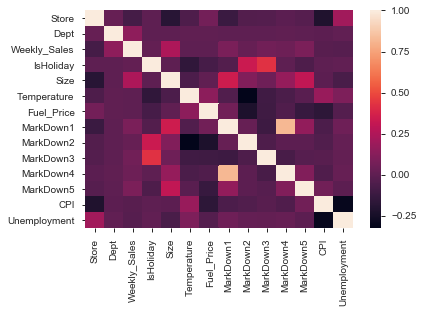

In [19]:
fig2 = sns.heatmap(new_test.corr())
fig2;

### Data Exploratory Analysis

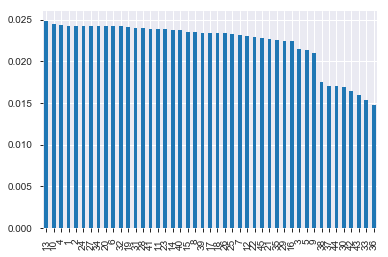

In [20]:
fig3 = new_train['Store'].value_counts(normalize=True).plot(kind ='bar')
fig3;

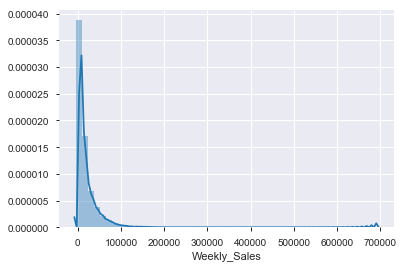

In [21]:
fig4 = sns.distplot(new_train.Weekly_Sales)
fig4;

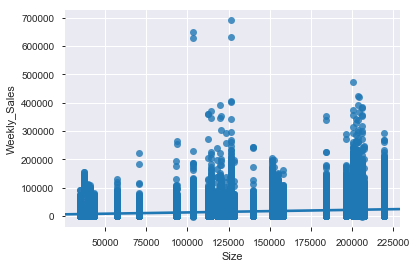

In [22]:
#Visualizing Size with Weekly Sales
fig4 = sns.regplot(x = 'Size', y = 'Weekly_Sales', data = new_train)
fig4;

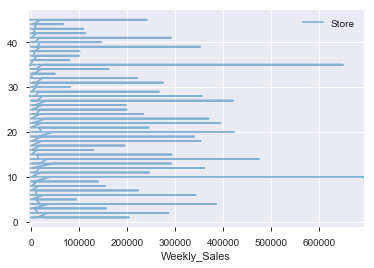

In [23]:
# Store Size vs Weekly Sales in line
fig5 = new_train.plot(kind = 'line', x='Weekly_Sales', y='Store', alpha =0.5)
fig5;

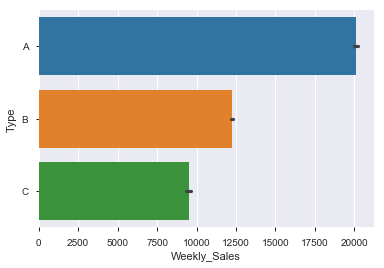

In [24]:
#Visulalizing Weekly Sales vs Type
fig7 = sns.barplot(x=new_train['Weekly_Sales'], y=new_train['Type'])
fig7;

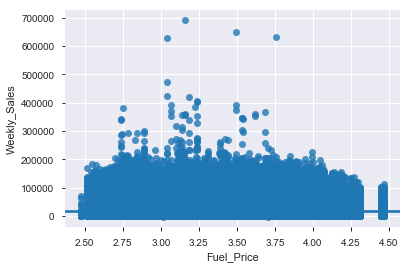

In [25]:
#Visualizing Fuel Price with Weekly Sales
fig8 = sns.regplot(x='Fuel_Price', y='Weekly_Sales', data=new_train)
fig8;

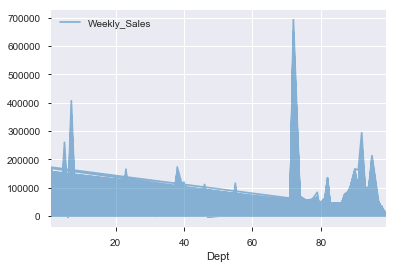

In [26]:
#Visulalizing Weekly Sales vs Department
fig9 = new_train.plot(kind ='line', x ='Dept', y ='Weekly_Sales', alpha=1.5)
fig9;

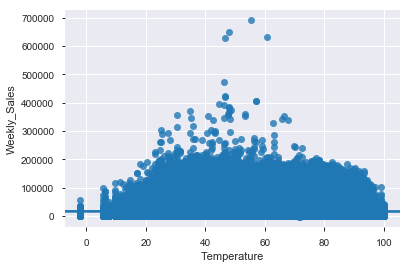

In [27]:
#Visualizing Temperature with Weekly Sales
fig10 = sns.regplot(x='Temperature', y ='Weekly_Sales', data = new_train)
fig10;

In [28]:
#coverting date into date format
new_train['Date'] = pd.to_datetime(new_train['Date'])
new_test['Date'] = pd.to_datetime(new_test['Date'])

In [29]:
#Converting Transport Type into numeric for train
new_train['Type'] = new_train['Type'].replace('A', 1)
new_train['Type'] = new_train['Type'].replace('B', 2)
new_train['Type'] = new_train['Type'].replace('C', 3)

In [30]:
#Converting Transport Type into numeric for test
new_test['Type'] = new_test['Type'].replace('A', 1)
new_test['Type'] = new_test['Type'].replace('B', 2)
new_test['Type'] = new_test['Type'].replace('C', 3)

### Outliers Treatment

In [31]:
def outliers_treatment(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

In [32]:
new_train = new_train.apply(outliers_treatment)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
new_test = new_test.apply(outliers_treatment)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  This is separate from the ipykernel package so we can avoid doing imports until


### Missing Value Treatment

In [34]:
print(new_train.isnull().sum())
print()
print(new_test.isnull().sum())

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64


In [35]:
new_train=new_train.fillna(0)
new_test=new_test.fillna(0)

In [36]:
print(new_train.isnull().sum())
print()
print(new_test.isnull().sum())

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64


### Extract date features

In [37]:
new_train['Date_Day'] = new_train['Date'].dt.day
new_train['Date_Week'] = new_train['Date'].dt.week
new_train['Date_Month'] = new_train['Date'].dt.month
new_train['Date_Year'] = new_train['Date'].dt.year

In [38]:
new_test['Date_Day'] = new_test['Date'].dt.day
new_test['Date_Week'] = new_test['Date'].dt.week
new_test['Date_Month'] = new_test['Date'].dt.month
new_test['Date_Year'] = new_test['Date'].dt.year

### Defining Holidays

In [39]:
from datetime import datetime

In [40]:
new_train['Super_Bowl'] = np.where((new_train['Date']==datetime(2010, 2, 12)) | (new_train['Date']==datetime(2011, 2, 11)) | (new_train['Date']==datetime(2012, 2, 10)), 1,0)
new_train['Labour_Day'] = np.where((new_train['Date']==datetime(2010, 9, 10)) | (new_train['Date']==datetime(2011, 9, 9)) | (new_train['Date']==datetime(2012, 9, 7)),1,0)
new_train['Thanksgiving'] = np.where((new_train['Date']==datetime(2010, 11, 26)) | (new_train['Date']==datetime(2011, 11, 25)) | (new_train['Date']==datetime(2012, 11, 23)),1,0)
new_train['Christmas'] = np.where((new_train['Date']==datetime(2010, 12, 31)) | (new_train['Date']==datetime(2011, 12, 30)) | (new_train['Date']==datetime(2012, 12, 28)),1,0)

In [41]:
new_test['Super_Bowl'] = np.where((new_test['Date']== datetime(2010, 2, 12)) | (new_test['Date'] == datetime(2011, 2, 11)) | (new_test['Date']==datetime(2012, 2, 10)), 1,0)
new_test['Labour_Day'] = np.where((new_test['Date']==datetime(2010, 9, 10)) | (new_test['Date']==datetime(2011, 9, 9)) | (new_test['Date']==datetime(2012, 9, 7)),1,0)
new_test['Thanksgiving'] = np.where((new_test['Date']==datetime(2010, 11, 26)) | (new_test['Date']==datetime(2011, 11, 25)) | (new_test['Date']==datetime(2012, 11, 23)),1,0)
new_test['Christmas'] = np.where((new_test['Date']==datetime(2010, 12, 31)) | (new_test['Date']==datetime(2011, 12, 30)) | (new_test['Date']==datetime(2012, 12, 28)),1,0)

In [42]:
new_train

Store  Dept       Date  Weekly_Sales  IsHoliday  Type    Size  \
0           1     1 2010-02-12      24924.50      False     1  151315   
1           1     2 2010-02-12      50605.27      False     1  151315   
2           1     3 2010-02-12      13740.12      False     1  151315   
3           1     4 2010-02-12      39954.04      False     1  151315   
4           1     5 2010-02-12      32229.38      False     1  151315   
5           1     6 2010-02-12       5749.03      False     1  151315   
6           1     7 2010-02-12      21084.08      False     1  151315   
7           1     8 2010-02-12      40129.01      False     1  151315   
8           1     9 2010-02-12      16930.99      False     1  151315   
9           1    10 2010-02-12      30721.50      False     1  151315   
10          1    11 2010-02-12      24213.18      False     1  151315   
11          1    12 2010-02-12       8449.54      False     1  151315   
12          1    13 2010-02-12      41969.29      False     1  151315   
13          1    14 2010-02-12      19466.91      False     1  151315   
14          1    16 2010-02-12      10217.55      False     1  151315   
15          1    17 2010-02-12      13223.76      False     1  151315   
16          1    18 2010-02-12       4729.50      False     1  151315   
17          1    19 2010-02-12       1947.05      False     1  151315   
18          1    20 2010-02-12       5034.10      False     1  151315   
19          1    21 2010-02-12       8907.63      False     1  151315   
20          1    22 2010-02-12      13623.98      False     1  151315   
21          1    23 2010-02-12      24146.49      False     1  151315   
22          1    24 2010-02-12       8272.90      False     1  151315   
23          1    25 2010-02-12      11609.50      False     1  151315   
24          1    26 2010-02-12      11737.12      False     1  151315   
25          1    27 2010-02-12       2293.00      False     1  151315   
26          1    28 2010-02-12       1085.29      False     1  151315   
27          1    29 2010-02-12       7024.95      False     1  151315   
28          1    30 2010-02-12       5491.00      False     1  151315   
29          1    31 2010-02-12       3455.92      False     1  151315   
...       ...   ...        ...           ...        ...   ...     ...   
421540     45    41 2012-10-19       1954.67      False     2  118221   
421541     45    42 2012-10-19       4894.78      False     2  118221   
421542     45    44 2012-10-19       3144.09      False     2  118221   
421543     45    46 2012-10-19      13329.25      False     2  118221   
421544     45    52 2012-10-19       1104.16      False     2  118221   
421545     45    54 2012-10-19         23.92      False     2  118221   
421546     45    55 2012-10-19       3458.17      False     2  118221   
421547     45    56 2012-10-19        937.72      False     2  118221   
421548     45    58 2012-10-19        275.00      False     2  118221   
421549     45    59 2012-10-19        191.98      False     2  118221   
421550     45    60 2012-10-19        117.00      False     2  118221   
421551     45    67 2012-10-19       5772.09      False     2  118221   
421552     45    71 2012-10-19       2789.38      False     2  118221   
421553     45    72 2012-10-19      33366.60      False     2  118221   
421554     45    74 2012-10-19       9814.88      False     2  118221   
421555     45    79 2012-10-19      14618.60      False     2  118221   
421556     45    80 2012-10-19        670.88      False     2  118221   
421557     45    81 2012-10-19      14693.09      False     2  118221   
421558     45    82 2012-10-19      17360.33      False     2  118221   
421559     45    83 2012-10-19        717.82      False     2  118221   
421560     45    85 2012-10-19       1689.10      False     2  118221   
421561     45    87 2012-10-19       8187.66      False     2  118221   
421562     45    90 2012-10-19      25352.32      False     2  118

In [43]:
train_test_df = [new_train, new_test]

In [44]:
# Converting Categorical Variable IsHoliday into Numerical Variable 

type_mapping = {False: 0, True: 1}
for dataset in train_test_df:
    dataset['IsHoliday'] = dataset['IsHoliday'].map(type_mapping)

In [45]:
new_train

Store  Dept       Date  Weekly_Sales  IsHoliday  Type    Size  \
0           1     1 2010-02-12      24924.50          0     1  151315   
1           1     2 2010-02-12      50605.27          0     1  151315   
2           1     3 2010-02-12      13740.12          0     1  151315   
3           1     4 2010-02-12      39954.04          0     1  151315   
4           1     5 2010-02-12      32229.38          0     1  151315   
5           1     6 2010-02-12       5749.03          0     1  151315   
6           1     7 2010-02-12      21084.08          0     1  151315   
7           1     8 2010-02-12      40129.01          0     1  151315   
8           1     9 2010-02-12      16930.99          0     1  151315   
9           1    10 2010-02-12      30721.50          0     1  151315   
10          1    11 2010-02-12      24213.18          0     1  151315   
11          1    12 2010-02-12       8449.54          0     1  151315   
12          1    13 2010-02-12      41969.29          0     1  151315   
13          1    14 2010-02-12      19466.91          0     1  151315   
14          1    16 2010-02-12      10217.55          0     1  151315   
15          1    17 2010-02-12      13223.76          0     1  151315   
16          1    18 2010-02-12       4729.50          0     1  151315   
17          1    19 2010-02-12       1947.05          0     1  151315   
18          1    20 2010-02-12       5034.10          0     1  151315   
19          1    21 2010-02-12       8907.63          0     1  151315   
20          1    22 2010-02-12      13623.98          0     1  151315   
21          1    23 2010-02-12      24146.49          0     1  151315   
22          1    24 2010-02-12       8272.90          0     1  151315   
23          1    25 2010-02-12      11609.50          0     1  151315   
24          1    26 2010-02-12      11737.12          0     1  151315   
25          1    27 2010-02-12       2293.00          0     1  151315   
26          1    28 2010-02-12       1085.29          0     1  151315   
27          1    29 2010-02-12       7024.95          0     1  151315   
28          1    30 2010-02-12       5491.00          0     1  151315   
29          1    31 2010-02-12       3455.92          0     1  151315   
...       ...   ...        ...           ...        ...   ...     ...   
421540     45    41 2012-10-19       1954.67          0     2  118221   
421541     45    42 2012-10-19       4894.78          0     2  118221   
421542     45    44 2012-10-19       3144.09          0     2  118221   
421543     45    46 2012-10-19      13329.25          0     2  118221   
421544     45    52 2012-10-19       1104.16          0     2  118221   
421545     45    54 2012-10-19         23.92          0     2  118221   
421546     45    55 2012-10-19       3458.17          0     2  118221   
421547     45    56 2012-10-19        937.72          0     2  118221   
421548     45    58 2012-10-19        275.00          0     2  118221   
421549     45    59 2012-10-19        191.98          0     2  118221   
421550     45    60 2012-10-19        117.00          0     2  118221   
421551     45    67 2012-10-19       5772.09          0     2  118221   
421552     45    71 2012-10-19       2789.38          0     2  118221   
421553     45    72 2012-10-19      33366.60          0     2  118221   
421554     45    74 2012-10-19       9814.88          0     2  118221   
421555     45    79 2012-10-19      14618.60          0     2  118221   
421556     45    80 2012-10-19        670.88          0     2  118221   
421557     45    81 2012-10-19      14693.09          0     2  118221   
421558     45    82 2012-10-19      17360.33          0     2  118221   
421559     45    83 2012-10-19        717.82          0     2  118221   
421560     45    85 2012-10-19       1689.10          0     2  118221   
421561     45    87 2012-10-19       8187.66          0     2  118221   
421562     45    90 2012-10-19      25352.32          0     2  118

In [46]:
# Altering the isHoliday value depending on new holidays we defined above
new_train['IsHoliday']=new_train['IsHoliday']|new_train['Super_Bowl']|new_train['Labour_Day']|new_train['Thanksgiving']|new_train['Christmas']
new_test['IsHoliday']=new_test['IsHoliday']|new_test['Super_Bowl']|new_test['Labour_Day']|new_test['Thanksgiving']|new_test['Christmas']

In [47]:
# Since we have Imputed IsHoliday according to new holidays created above
# So, now droping the Extra holiday features because its redundant

new_train.drop(['Super_Bowl','Labour_Day','Thanksgiving','Christmas'], axis=1, inplace=True)

new_test.drop(['Super_Bowl','Labour_Day','Thanksgiving','Christmas'], axis=1, inplace=True)

In [48]:
train_X=new_train.drop(['Weekly_Sales','Date'], axis=1)
train_y=new_train['Weekly_Sales'] 

test_X=new_test.drop(['Weekly_Sales','Date'], axis=1)
test_y=new_test['Weekly_Sales']

train_X.shape, train_y.shape, test_X.shape, test_y.shape,

((421570, 18), (421570,), (421570, 18), (421570,))

## Building models

In [49]:
from sklearn.linear_model import LinearRegression
lm= LinearRegression()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)

from sklearn.pipeline import make_pipeline


from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.feature_selection import SelectKBest
from sklearn.neural_network import MLPClassifier

### 1.Linear Regression

In [50]:
lm = LinearRegression()
lm.fit(train_X, train_y)
y_pred_linear = lm.predict(test_X)
accuracy_linear = round((lm.score(train_X, train_y)) * 100, 2)
print('score:' +str(accuracy_linear) + '%')

score:9.01%


### 2. Random Forest

In [51]:
clf = RandomForestRegressor(n_estimators=100)
clf.fit(train_X, train_y)
y_pred_rf=clf.predict(test_X)
accuracy_rf= round(clf.score(train_X, train_y) * 100, 2)
print(str(accuracy_rf) + ' %')

99.76 %


### 3. Decision Tree

In [52]:
clf=DecisionTreeRegressor()
clf.fit(train_X, train_y)
y_pred_dt= clf.predict(test_X)
accuracy_dt = round( clf.score(train_X, train_y) * 100, 2)
print (str(accuracy_dt) + ' %')

99.97 %


In [53]:
models = pd.DataFrame({
    'Model': ['Linear Regression','Random Forest','Decision Tree'],
    
    'Score': [accuracy_linear, accuracy_rf, accuracy_dt]
    })

models.sort_values(by='Score', ascending=False)

Model  Score
2      Decision Tree  99.97
1      Random Forest  99.76
0  Linear Regression   9.01

In [54]:
new_train.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Type    Size  Temperature  \
0      1     1 2010-02-12      24924.50          1     1  151315        42.31   
1      1     2 2010-02-12      50605.27          1     1  151315        42.31   
2      1     3 2010-02-12      13740.12          1     1  151315        42.31   
3      1     4 2010-02-12      39954.04          1     1  151315        42.31   
4      1     5 2010-02-12      32229.38          1     1  151315        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        0.0        0.0        0.0        0.0        0.0   
1       2.572        0.0        0.0        0.0        0.0        0.0   
2       2.572        0.0        0.0        0.0        0.0        0.0   
3       2.572        0.0        0.0        0.0        0.0        0.0   
4       2.572        0.0        0.0        0.0        0.0        0.0   

          CPI  Unemployment  Date_Day  Date_Week  Date_Month  Date_Year  
0  211.096358         8.106        12          6           2       2010  
1  211.096358         8.106        12          6           2       2010  
2  211.096358         8.106        12          6           2       2010  
3  211.096358         8.106        12          6           2       2010  
4  211.096358         8.106        12          6           2       2010

In [55]:
new_test.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Type    Size  Temperature  \
0      1     1 2010-02-12      24924.50          1     1  151315        42.31   
1      1     2 2010-02-12      50605.27          1     1  151315        42.31   
2      1     3 2010-02-12      13740.12          1     1  151315        42.31   
3      1     4 2010-02-12      39954.04          1     1  151315        42.31   
4      1     5 2010-02-12      32229.38          1     1  151315        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        0.0        0.0        0.0        0.0        0.0   
1       2.572        0.0        0.0        0.0        0.0        0.0   
2       2.572        0.0        0.0        0.0        0.0        0.0   
3       2.572        0.0        0.0        0.0        0.0        0.0   
4       2.572        0.0        0.0        0.0        0.0        0.0   

          CPI  Unemployment  Date_Day  Date_Week  Date_Month  Date_Year  
0  211.096358         8.106        12          6           2       2010  
1  211.096358         8.106        12          6           2       2010  
2  211.096358         8.106        12          6           2       2010  
3  211.096358         8.106        12          6           2       2010  
4  211.096358         8.106        12          6           2       2010

In [56]:
# Prediction value using Random Forest model..
submission = pd.DataFrame({
        "Store_Dept_Date": new_test.Type.astype(str)+'_'+new_test.Dept.astype(str)+'_'+new_test.Date.astype(str),
        "Weekly_Sales": y_pred_rf
    })

In [57]:
submission.to_csv('weekly_sales predicted.csv', index=False)
submission.to_excel(writer,'Weekly_sales Pred', index=False)

In [58]:
submission.head()

Store_Dept_Date  Weekly_Sales
0  1_1_2010-02-12    32696.9468
1  1_2_2010-02-12    49052.9467
2  1_3_2010-02-12    12970.4047
3  1_4_2010-02-12    38208.7579
4  1_5_2010-02-12    31263.2153